In [1]:
import copy
import datetime
import itertools
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection

In [2]:
### IMPORT DATASET ###

X, y = datasets.fetch_california_housing(return_X_y=True, as_frame=True)

X.shape, y.shape

((20640, 8), (20640,))

In [3]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, shuffle=True, test_size=10_000, train_size=10_000,
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10000, 8), (10000, 8), (10000,), (10000,))

In [4]:
### TRAIN AND OPTIMIZE DEEP MODEL ###

CV = model_selection.KFold(5, shuffle=False)

model = model_selection.RandomizedSearchCV(
    ctb.CatBoostRegressor(verbose=0, thread_count=-1, random_state=123), 
    {'n_estimators': stats.randint(1, 300), 
     'depth': [4, 6, 8, 10]}, 
    random_state=123, n_iter=20, refit=True,
    cv=CV, scoring='neg_mean_absolute_error'
).fit(X_train, y_train)

model.best_score_, model.best_params_

(-0.30992616367819387, {'depth': 8, 'n_estimators': 291})

In [5]:
### COMPUTE SHAP WITH BEST MODEL ###

class ShapCatBoostRegressor(ctb.CatBoostRegressor):
    def predict_shap(self, X):
        return self.get_feature_importance(
            ctb.Pool(X), type='ShapValues'
        )

ref_shap_val = model_selection.cross_val_predict(
    ShapCatBoostRegressor(
        **model.best_params_, 
        verbose=0, thread_count=-1, random_state=123
    ),
    X_train, y_train,
    method='predict_shap',
    cv=CV 
)

shap_feat_importance = np.abs(ref_shap_val[:,:-1]).mean(0)
shap_feat_importance /= shap_feat_importance.sum()

In [6]:
### SEARCH FOR LOWER PARAMS AND COMPUTE SHAP ###

result = []
param_combi = {'iters': range(5,125,5), 'depth': range(1,8)}
for i,d in tqdm(itertools.product(*param_combi.values()), 
                total=np.prod(list(map(len, param_combi.values())))):
    
    start_time = datetime.datetime.now()
    shap_val = model_selection.cross_val_predict(
        ShapCatBoostRegressor(
            n_estimators=i, depth=d, 
            verbose=0, thread_count=-1, random_state=123
        ),
        X_train, y_train,
        method='predict_shap',
        cv=CV 
    )
    end_time = datetime.datetime.now()
    delta = (end_time - start_time).total_seconds()
    
    result.append({
        "time": delta,
        "iters": i,
        "depth": d,
        "r2_feat_shap": np.average(
                metrics.r2_score(
                    ref_shap_val[:,:-1], shap_val[:,:-1], 
                    multioutput='raw_values'
                ).round(3),
            weights=shap_feat_importance
        ),
        "r2_sample_shap": metrics.r2_score(
            ref_shap_val[:,:-1].sum(1), shap_val[:,:-1].sum(1)
        ),
    })
    
    
result = pd.DataFrame(result)

result.iloc[[0,1,-2,-1]]

  0%|          | 0/168 [00:00<?, ?it/s]

,time,iters,depth,r2_feat_shap,r2_sample_shap
0,0.600969,5,1,0.228495,0.579536
1,0.562077,5,2,0.355939,0.688217
166,2.722846,120,6,0.929624,0.973461
167,4.352431,120,7,0.936630,0.973156


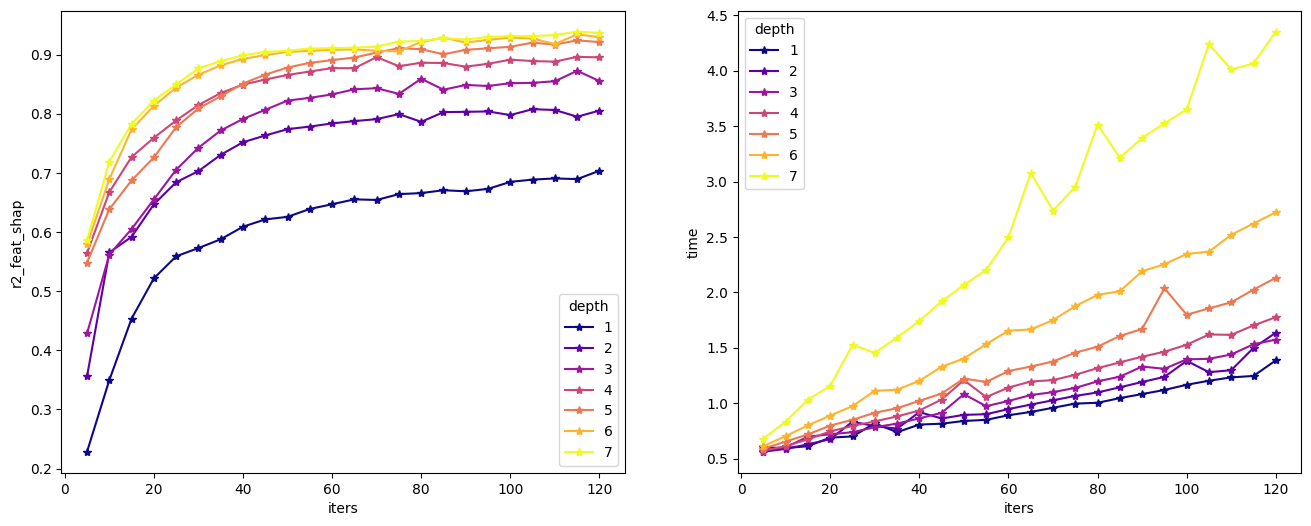

In [7]:
### R2 SHAP vs ITERATIONS ###

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
result.pivot(index='iters', columns="depth", values="r2_feat_shap").plot(
    ax=plt.gca(), marker='*', cmap='plasma', ylabel='r2_feat_shap'
)
plt.subplot(1,2,2)
result.pivot(index='iters', columns="depth", values="time").plot(
    ax=plt.gca(), marker='*', cmap='plasma', ylabel='time'
)
plt.show()

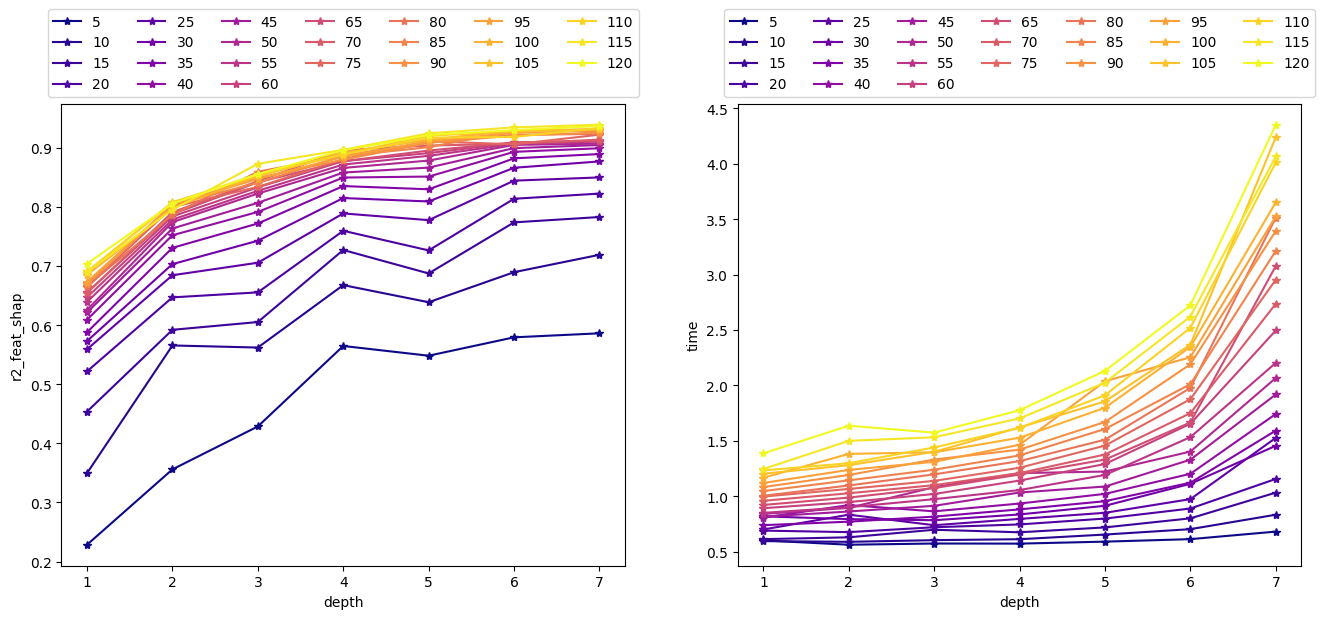

In [8]:
### R2 SHAP vs DEPTH ###

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
result.pivot(index='depth', columns="iters", values="r2_feat_shap").plot(
    ax=plt.gca(), marker='*', cmap='plasma', ylabel='r2_feat_shap'
)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
           ncol=7, fancybox=True)
plt.subplot(1,2,2)
result.pivot(index='depth', columns="iters", values="time").plot(
    ax=plt.gca(), marker='*', cmap='plasma', ylabel='time'
)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22),
           ncol=7, fancybox=True)
plt.show()

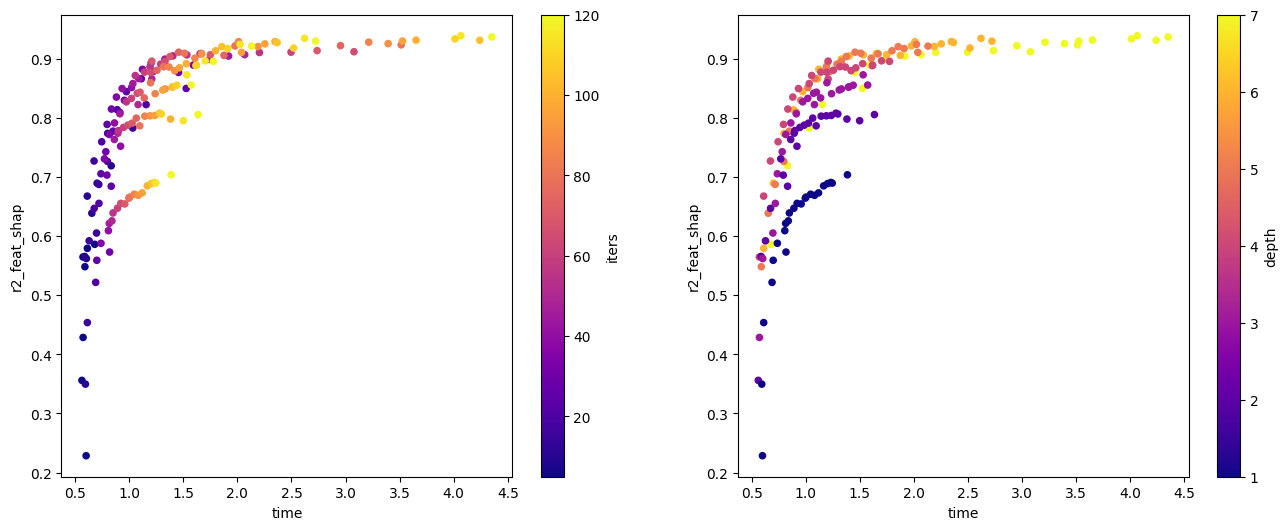

In [9]:
### PLOT ALL PARAMS COMBINATIONS ###

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
result.plot.scatter('time', 'r2_feat_shap', c='iters', cmap='plasma', ax=plt.gca())
plt.subplot(1,2,2)
result.plot.scatter('time', 'r2_feat_shap', c='depth', cmap='plasma', ax=plt.gca())
plt.show()

In [10]:
### SEARCHING FOR OPTIMAL PARAMS COMBI ###

def distance(time, r2, w_time=0.1, w_r2=0.9):
    return ((time - result.time.min()) **2) *w_time + \
            ((result.r2_feat_shap.max() - r2) **2) *w_r2

result['distance'] = result.apply(
    lambda x: distance(x.time, x.r2_feat_shap), axis=1
)
result = result.sort_values('distance')

result.head()

,time,iters,depth,r2_feat_shap,r2_sample_shap,distance
45,0.881129,35,4,0.835055,0.942079,0.019869
52,0.933902,40,4,0.849478,0.945454,0.021009
38,0.835337,30,4,0.814801,0.936066,0.021309
26,0.888775,20,6,0.813595,0.936187,0.024785
33,0.973460,25,6,0.844227,0.943921,0.024976


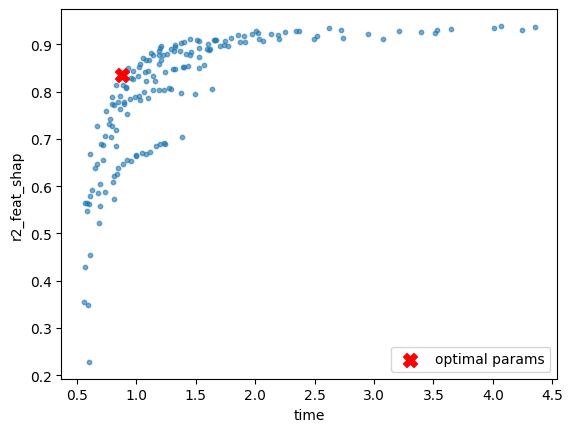

In [11]:
### PLOT OPTIMAL PARAMS COMBI ###

result.plot.scatter('time', 'r2_feat_shap', alpha=0.6, s=10)
plt.scatter(result.head(1).time, result.head(1).r2_feat_shap, 
            c='red', marker='X', s=100, label='optimal params')
plt.legend(); plt.show()

In [12]:
### FIT PROXY MODEL ###

proxy_model = ctb.CatBoostRegressor(
    n_estimators=result.head(1).iters.squeeze(), 
    depth=result.head(1).depth.squeeze(),
    verbose=0, thread_count=-1, random_state=123,
).fit(X_train, y_train)

In [13]:
%%time

### GET SHAP WITH PROXY MODEL ###
proxy_shap = proxy_model.get_feature_importance(
    ctb.Pool(X_test), type='ShapValues'
)
proxy_shap.shape

CPU times: user 1.24 s, sys: 24.6 ms, total: 1.26 s
Wall time: 365 ms


(10000, 9)

In [14]:
%%time

### GET SHAP WITH ORIGINAL MODEL ###
best_shap = model.best_estimator_.get_feature_importance(
    ctb.Pool(X_test), type='ShapValues'
)
best_shap.shape

CPU times: user 11.8 s, sys: 80.3 ms, total: 11.8 s
Wall time: 3.12 s


(10000, 9)

In [15]:
### GET SHAP R2 SCORES AND FEATURES IMPORTANCES ###

df_shap = pd.DataFrame(
    {(c,'real'): best_shap[:,i] for i,c in enumerate(X.columns)}
).join(
    pd.DataFrame(
        {(c,'proxy'): proxy_shap[:,i] for i,c in enumerate(X.columns)}
    )
)

shap_scores = pd.DataFrame(
    df_shap.T.groupby(level=0).apply(
        lambda x: {
            ('score','R2'): metrics.r2_score(
                x.loc[(x.name,'real')],
                x.loc[(x.name,'proxy')]
            ),
        }
    ).to_dict()
).T.join(
    df_shap.T.groupby(level=0, as_index=False) \
        .apply(lambda x: x.T.abs().mean()) \
        .to_frame('importance').unstack().reset_index(level=0, drop=True)
)

shap_scores

score importance          
                  R2      proxy      real
AveBedrms  -1.693819   0.043522  0.023338
AveOccup    0.909440   0.210622  0.202232
AveRooms    0.437537   0.072331  0.150211
HouseAge    0.576227   0.063291  0.053822
Latitude    0.908945   0.390213  0.502764
Longitude   0.894353   0.328951  0.414822
MedInc      0.771915   0.481606  0.335749
Population  0.394225   0.023077  0.027750

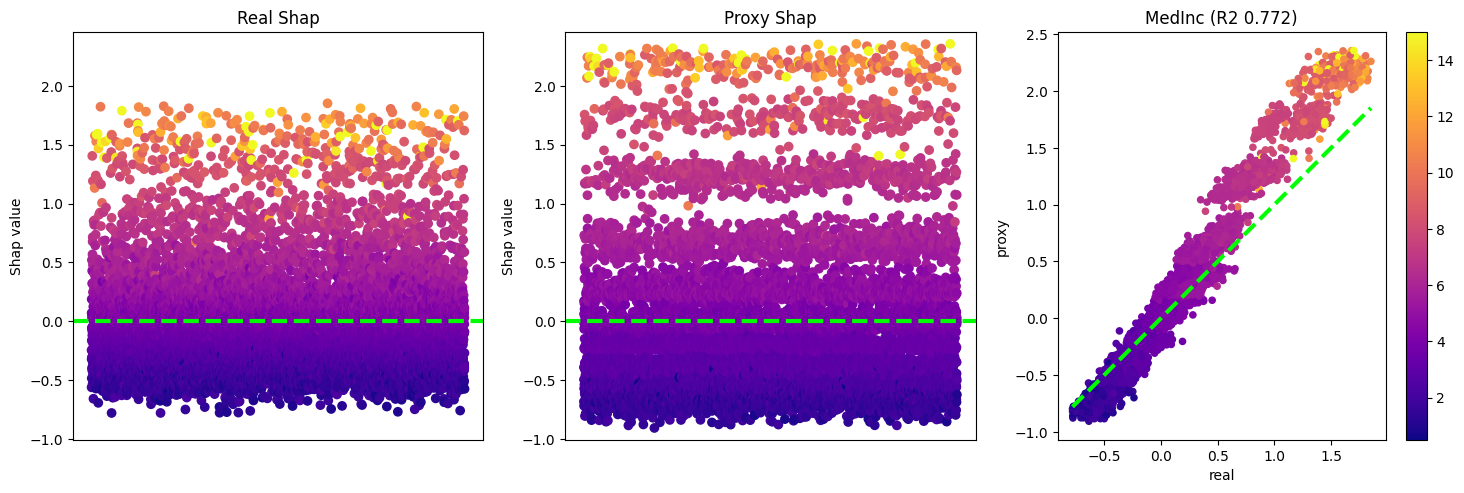

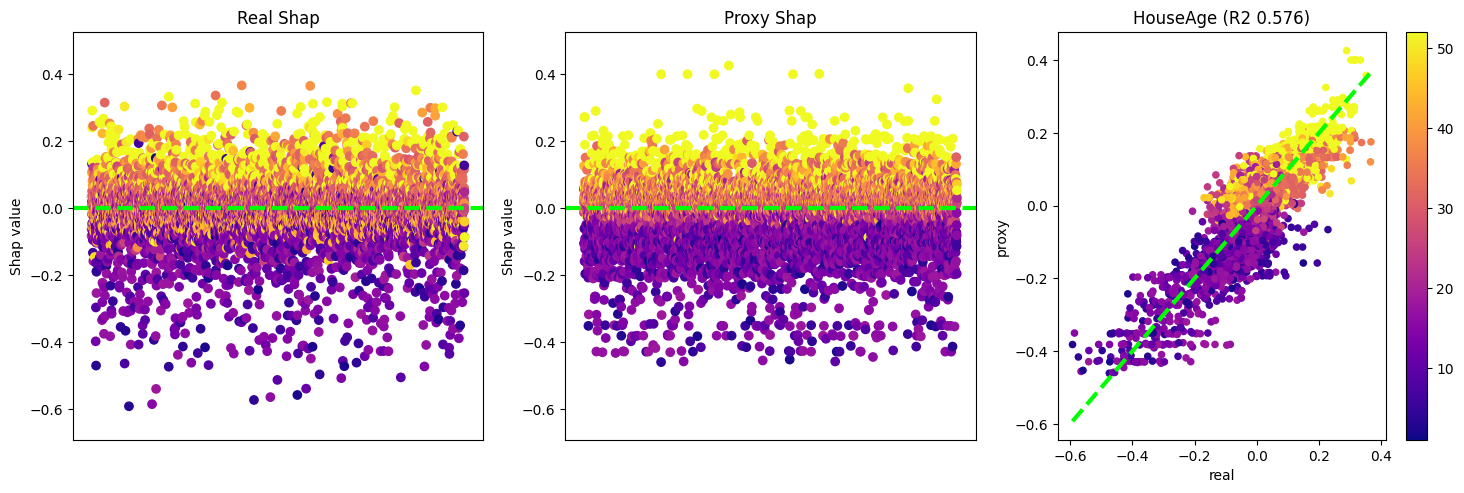

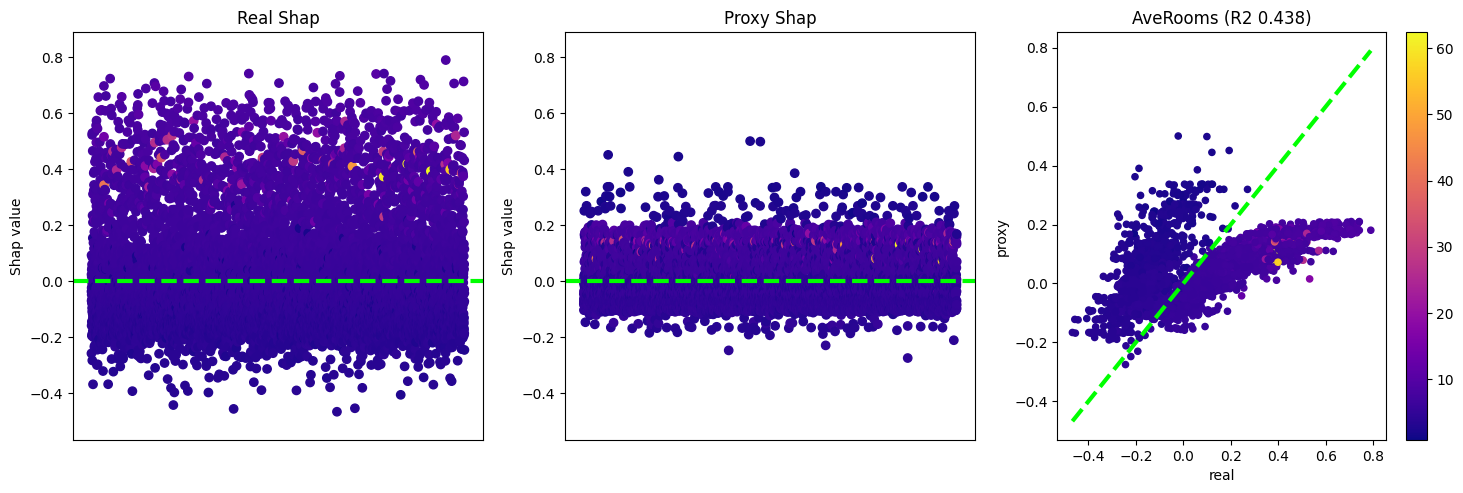

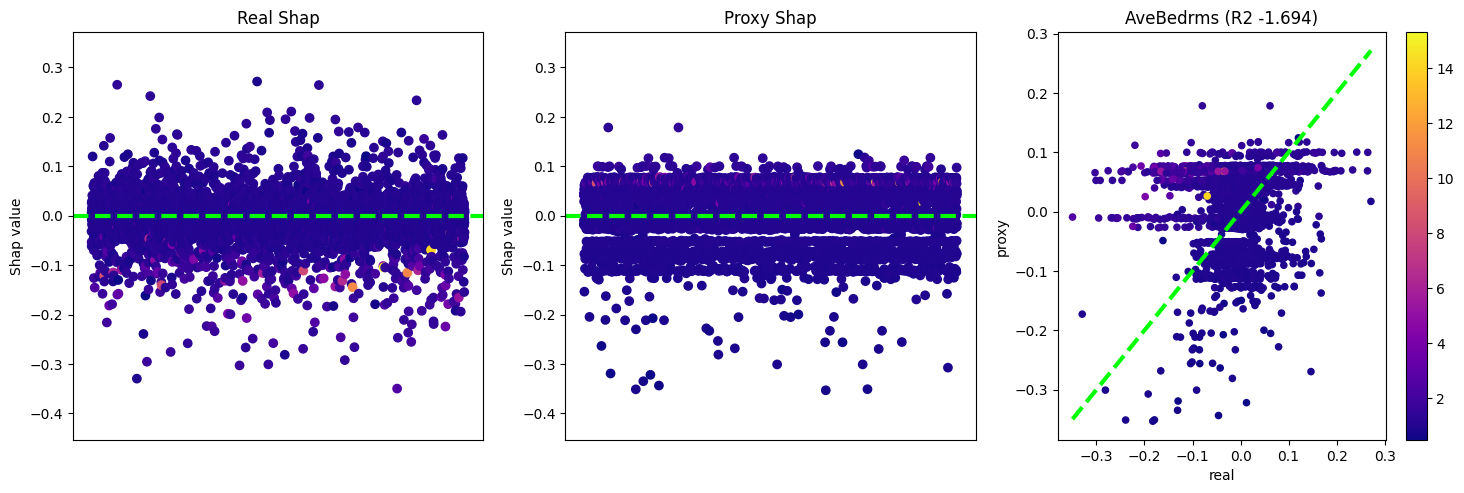

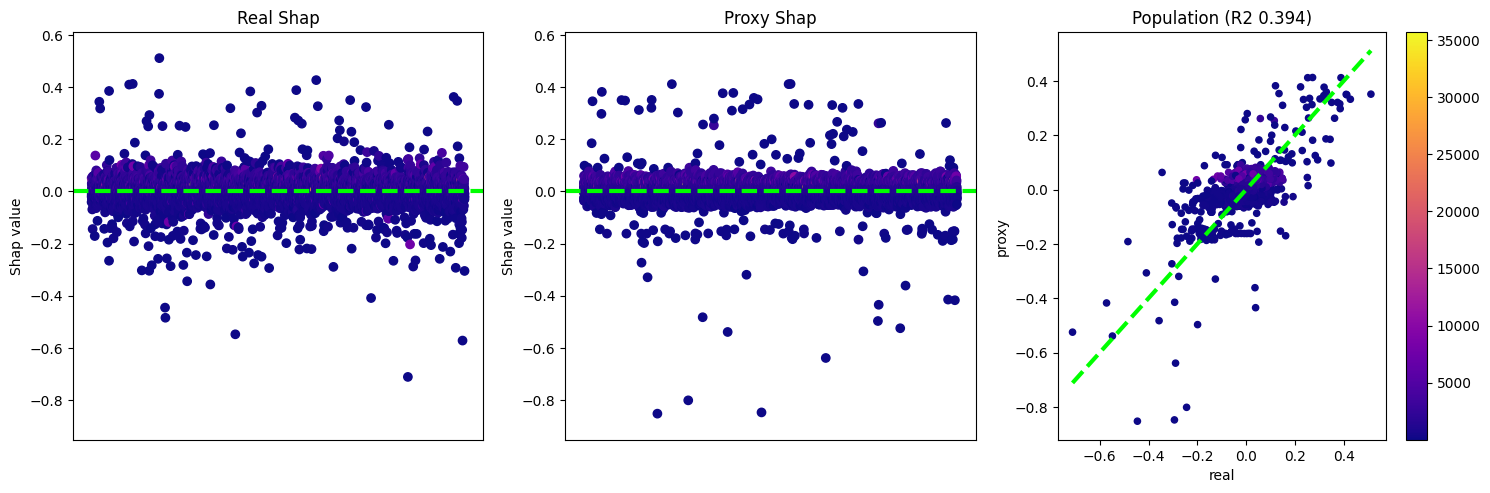

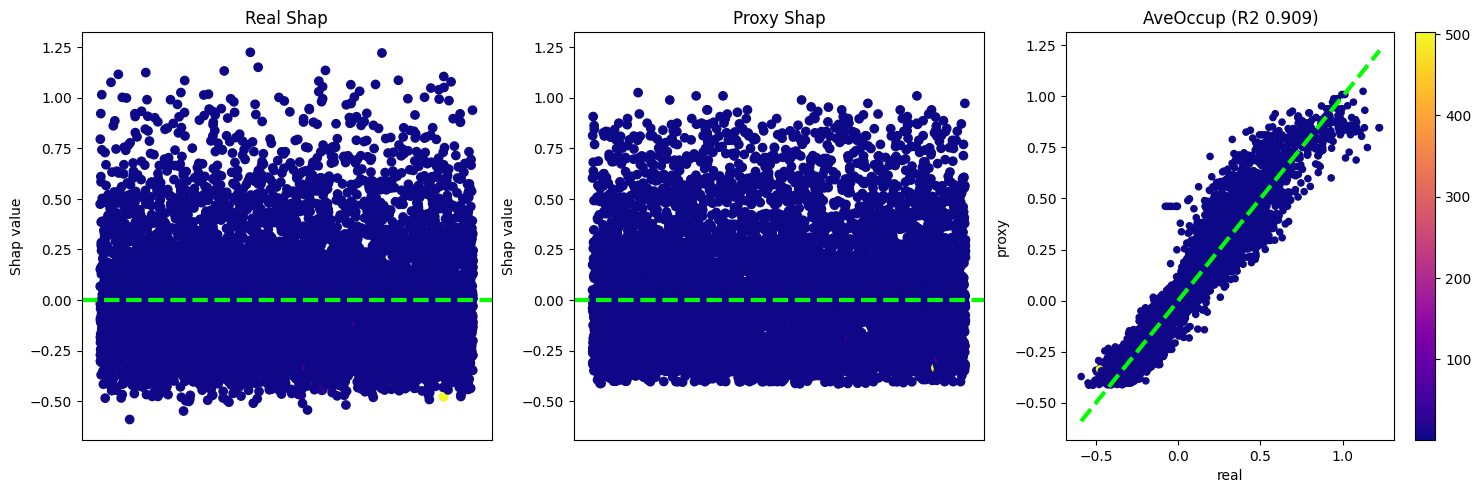

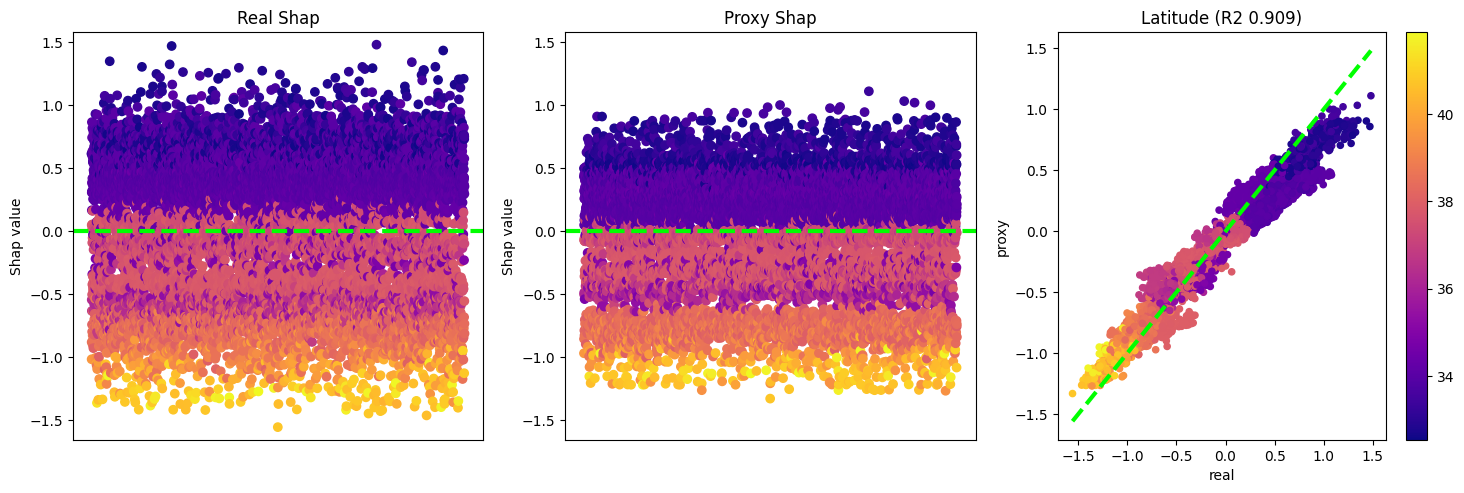

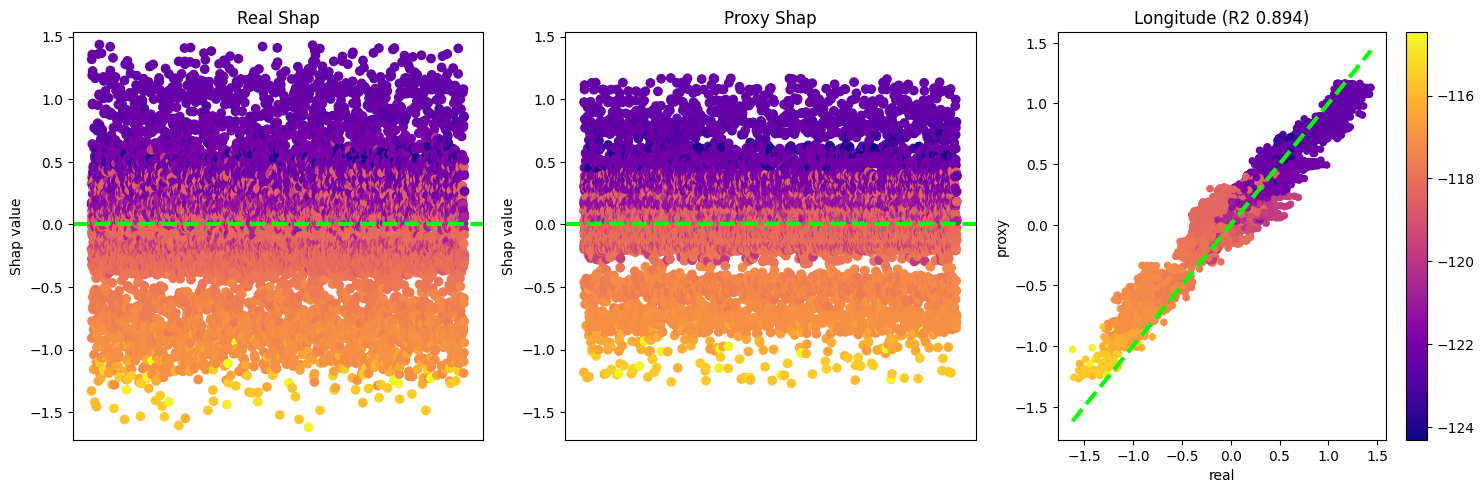

In [16]:
### PLOT PROXY SHAP vs REAL SHAP ###

for c in X:
    
    _ylim = [min(df_shap[(c,'real')].min(), df_shap[(c,'proxy')].min()) -0.1, 
             max(df_shap[(c,'real')].max(), df_shap[(c,'proxy')].max()) +0.1]
    plt.figure(figsize=(18,18))
    
    plt.subplot(3,3,1)
    plt.scatter(range(df_shap.shape[0]), df_shap[(c,'real')], 
                c=X_test[c], cmap='plasma')
    plt.ylim(_ylim)
    plt.axhline(0, linestyle='--', linewidth=3, c='lime')
    plt.xticks([]); plt.ylabel('Shap value'); plt.title('Real Shap')
    
    plt.subplot(3,3,2)
    plt.scatter(range(df_shap.shape[0]), df_shap[(c,'proxy')], 
                c=X_test[c], cmap='plasma')
    plt.ylim(_ylim)
    plt.axhline(0, linestyle='--', linewidth=3, c='lime')
    plt.xticks([]); plt.ylabel('Shap value'); plt.title('Proxy Shap')
    
    plt.subplot(3,3,3)
    df_shap[c].plot.scatter('real', 'proxy', c=X_test[c], 
                            cmap='plasma', ax=plt.gca())
    plt.plot([df_shap[(c,'real')].min(), df_shap[(c,'real')].max()],
             [df_shap[(c,'real')].min(), df_shap[(c,'real')].max()],
            linestyle='--', linewidth=3, c='lime')
    plt.title(f"{c} (R2 {round(shap_scores.loc[c][('score','R2')], 3)})")
    
    plt.show()